<h1><center> Klasifikator </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

Potrebno je u anaconda prompt-u instalirati xgboost s:<br>
<code>conda install -c anaconda py-xgboost</code>

### Priprema

In [3]:
# potrebni paketi
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.core.pylabtools import figsize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# učitavanje svih značajki iz training skupa
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# učitavanje svih značajki iz testing skupa
features_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_test_features.csv")

# učitavanje svih značajki iz training skupa
selected_features = pd.read_csv('feature_selection_cv5')

In [201]:
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,visualc,___security_cookie,assume,callvirtualalloc,exportedentry,hardware,hkey_current_user,hkey_local_machine,sp-analysisfailed,unableto
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0,0,0,0,0,0,0,0,0,0
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,0,0,0,0,0,0,0,0,0,0
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0,0,0,0,0,0,0,0,0,0
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,0,0,2,0,0,0,0,0,0,0
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0,0,0,0,0,0,0,0,0,0


In [202]:
selected_features.head()

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109
0,0,2.758885,-4.815674,-4.096333,2.893119,-0.016949,1.489298,-0.917445,-0.154625,2.116624,...,-0.274711,-0.446083,-0.116583,0.306839,0.575130,-0.144894,-0.107258,0.008032,-0.116864,0.083622
1,1,6.134662,-0.169692,-3.905000,3.035733,0.640184,3.231605,-1.170238,-0.131043,1.789371,...,-0.460911,0.229723,-0.083208,0.657943,0.884249,-0.192932,0.606504,0.373321,-0.267877,-0.444894
2,2,4.059810,-3.441866,-3.402326,1.966009,-0.498861,3.190550,-0.307942,1.334257,1.602137,...,-0.478440,0.165971,-0.187721,-0.336234,-0.057554,0.532081,0.112597,0.226716,0.025902,0.230062
3,3,24.334193,24.624190,-2.402030,-2.457468,-7.806197,-11.639498,-1.542437,-7.717818,-1.286335,...,-0.626446,0.594472,-5.009640,-0.012198,-2.396363,2.214136,1.018487,-4.639328,2.057111,-2.315513
4,4,1.654627,-2.159101,-4.067454,0.906983,-1.385565,2.033060,2.029099,-0.506575,0.405023,...,-0.490275,-0.236857,-0.641590,0.546539,-0.247375,-0.278855,0.271770,-0.399150,-0.795818,0.933269


In [105]:
one_gram_features = features.iloc[:,2:258]
metadata_bytes_features = features.iloc[:,258:260]
entropy_features = features.iloc[:,260:462]
image_features = features.iloc[:,462:514]
string_length_features = features.iloc[:,514:630]
metadata_asm_features = features.iloc[:,630:632]
symbols_features = features.iloc[:,632:639]
opcode_features = features.iloc[:,639:732]
reg_features = features.iloc[:,732:758]
section_features = features.iloc[:,758:782]
dd_features = features.iloc[:,782:806]
api_features = features.iloc[:,806:1600]
key_features = features.iloc[:,1600:1695]

### random forest



In [8]:
def random_forest(X_train, X_test, y_train, y_test):
    
    clf = RandomForestClassifier(n_estimators=1000, n_jobs=4)
    clf.fit(X_train, y_train)
    pred_class = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    
    return pred_class,pred_prob
    

### extra tree

In [7]:
def extra_tree(X_train, X_test, y_train, y_test):
    
    clf = ExtraTreesClassifier(n_estimators=1000, n_jobs=4)
    param_grid = {
        'n_estimators': [200, 700],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    clf.fit(X_train, y_train)
    pred_class = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    
    return pred_class,pred_prob

###  confusion matrix

In [41]:
def make_and_plot_confusion_matrix(y_test, best_preds, title='Confusion matrix'):
    names = ['class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8', 'class 9']
    cm = confusion_matrix(y_test, best_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    norm_conf = []
    for i in cm:
        a = 0
        tmp_arr = []
        a = sum(i, 0)
        for j in i:
            tmp_arr.append(float(j)/float(a))
        norm_conf.append(tmp_arr)

    fig = plt.figure(figsize(10, 10))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    res = ax.imshow(np.array(norm_conf), cmap=plt.cm.Blues,
                    interpolation='nearest')

    width = len(cm)
    height = len(cm[0])

    for x in range(width):
        for y in range(height):
            ax.annotate(str(format(round(cm[x][y], 2))), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.title(title)
    cb = fig.colorbar(res)
    plt.xticks(range(width), names)
    plt.yticks(range(height), names)

### XGboost

In [170]:
def xgboost_basic(X_train, X_test, y_train):
    #za svaku klasu 
    param = {
        'booster' : 'gbtree',
        'eval_metric' : 'logloss',
        'scale_pos_weight' : 1.0,
        'nthread' : 8,
        'bst:colsample_bytree' : 0.5,
        #'seed' = seed,
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.3,  # the training step for each iteration
        'silent': 1,  # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 9}  # the number of classes that exist in this datset
    num_round = 50  # the number of training iterations
    y_train = [int(x-1) for x in y_train]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    bst = xgb.train(param, dtrain, num_round)
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    return best_preds, preds

<br>
<br>

Logloss:0.0959980582515088
Accuracy:0.9932536031892057


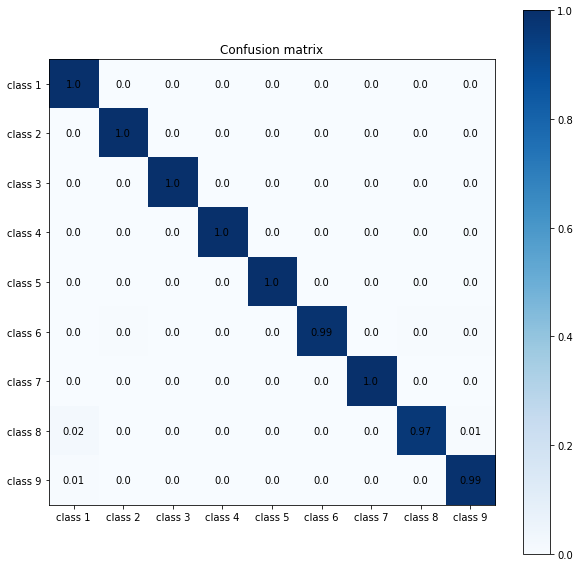

In [118]:
#all features
X=features.iloc[:,2:1695]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])


In [280]:
#every feature category
sve = []
cm_diagonal =[]

X_train, X_test, y_train, y_test = train_test_split( one_gram_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( metadata_bytes_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( entropy_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( image_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( string_length_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( metadata_asm_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( symbols_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( opcode_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( reg_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( section_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( dd_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( api_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())

X_train, X_test, y_train, y_test = train_test_split( key_features, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)
y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])
sve.append((score_log,score_acc))
cm = confusion_matrix(y_test, pred[0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_diagonal.append(cm.diagonal())


In [281]:
#scores of all feature categories 
pd.DataFrame(sve, columns=['log_loss','accuracy_score'])

,log_loss,accuracy_score
0,0.062701,0.981907
1,0.456335,0.843606
2,0.054130,0.985894
3,0.108394,0.972094
4,0.082609,0.979148
5,0.330646,0.917203
6,0.169785,0.955535
7,0.031769,0.992640
8,0.083747,0.979454
9,1.915182,0.258203


In [284]:
#diagonals of all confusion matrices
for list1 in cm_diagonal:
    for element in list1:
        print(str(format(round(element, 2))), end ="\t")
    print('')

0.99	0.99	1.0	0.95	0.71	0.95	0.99	0.94	0.99	
0.81	0.82	0.99	0.92	0.07	0.57	0.66	0.82	0.79	
0.99	0.99	1.0	0.98	0.5	0.97	0.99	0.95	1.0	
0.95	0.99	1.0	0.94	0.57	0.91	1.0	0.94	0.98	
0.97	0.98	1.0	1.0	0.5	0.96	1.0	0.94	0.99	
0.88	0.93	0.99	0.78	0.14	0.82	0.89	0.85	0.95	
0.92	0.96	1.0	0.92	0.5	0.92	0.94	0.92	0.98	
1.0	0.99	1.0	1.0	0.79	0.98	1.0	0.97	1.0	
0.96	0.99	1.0	0.98	0.64	0.96	0.97	0.95	0.99	
0.04	0.3	0.64	0.0	0.0	0.02	0.01	0.01	0.01	
0.03	0.27	0.7	0.0	0.0	0.01	0.01	0.02	0.01	
1.0	1.0	1.0	0.99	0.5	0.97	0.93	0.92	1.0	
0.99	1.0	1.0	1.0	0.86	0.98	1.0	0.98	0.99	


### selektirane značajke <br>

Logloss:0.05006839592836761
Accuracy:0.9871205151793928


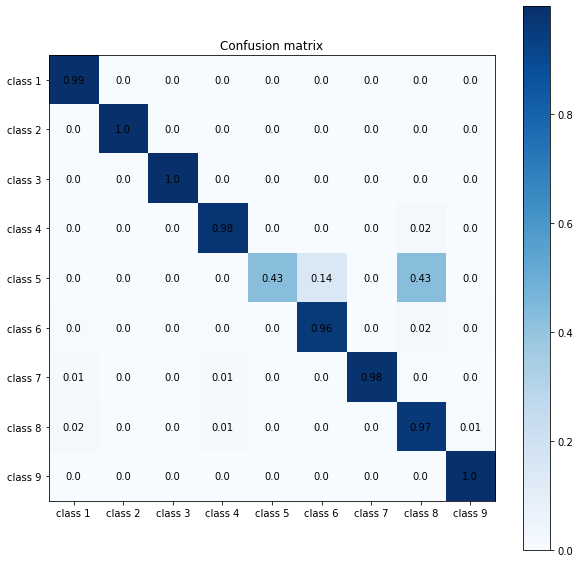

In [178]:
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

## nebalansiranost  ??????

### dodavanje težina u XGboost......baš i ne

In [58]:
def create_weights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights

Logloss : 
0.05035714877826751
Accuracy : 
0.9846672799754677


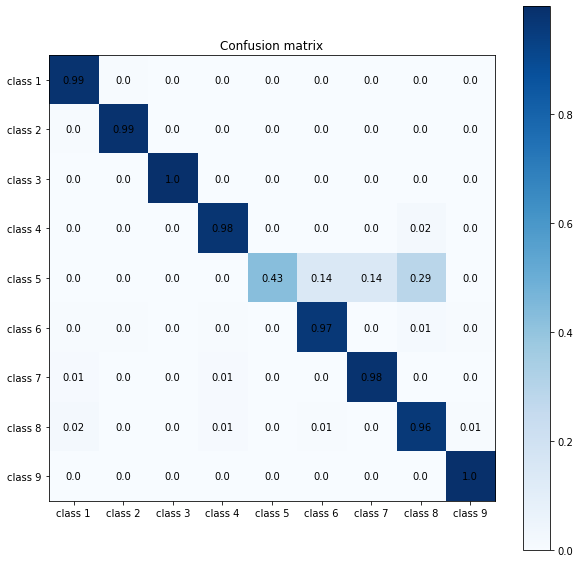

In [63]:
#adding weights to deal with unbalanced data

X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split(  X, features['Class'], test_size=0.3, random_state=47)

#w_array = np.ones(y_train.shape[0], dtype = 'float')
#for i, val in enumerate(y_train):
#    w_array[i] = class_weights[val-1]

y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

largest_class_weight_coef = max(y_train,key=y_train.count)/len(y_train)
w_array = create_weights(y_train, largest_class_weight_coef)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_array)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'booster' : 'gbtree',
    'eval_metric' : 'logloss',
    'nthread' : 8,
    'bst:colsample_bytree' : 0.5,
    #'seed' = seed,
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 9}  # the number of classes that exist in this datset
num_round = 50  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

score_log = log_loss(y_test,preds,eps=1e-15)
print('Logloss : ')
print(score_log)

score_acc = accuracy_score(y_test, best_preds)
print('Accuracy : ')
print(score_acc)

make_and_plot_confusion_matrix(y_test,best_preds)

### oversampling

Logloss:0.051979165193453754
Accuracy:0.9855872431769396


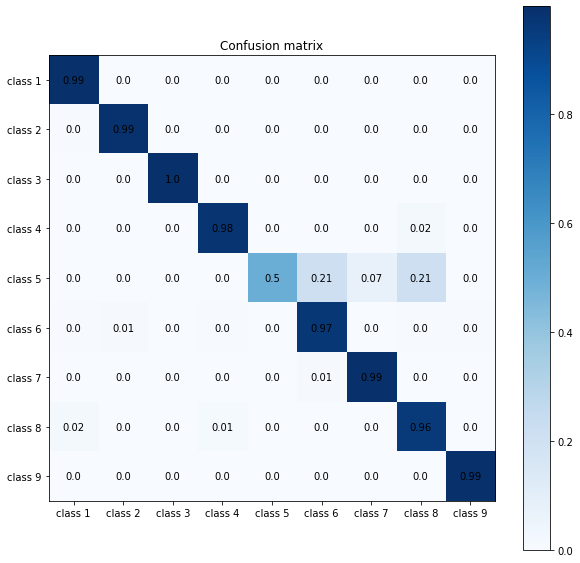

In [65]:
#RandomOverSampler
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

[(1, 2008), (2, 2008), (3, 2008), (4, 2008), (5, 2008), (6, 2008), (7, 2008), (8, 2008), (9, 2008)]
Logloss:0.05035765056692785
Accuracy:0.9855872431769396


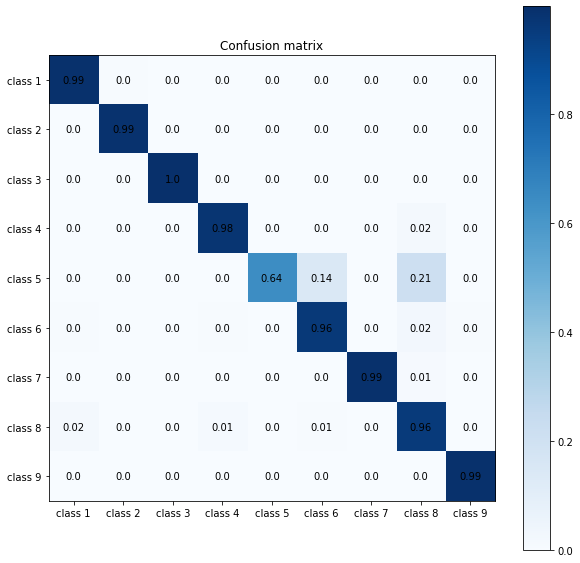

In [176]:
#SMOTE
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])


[(1, 1993), (2, 2007), (3, 2008), (4, 2006), (5, 2002), (6, 2010), (7, 2011), (8, 2020), (9, 2016)]
Logloss:0.048381991697384476
Accuracy:0.9874271695798835


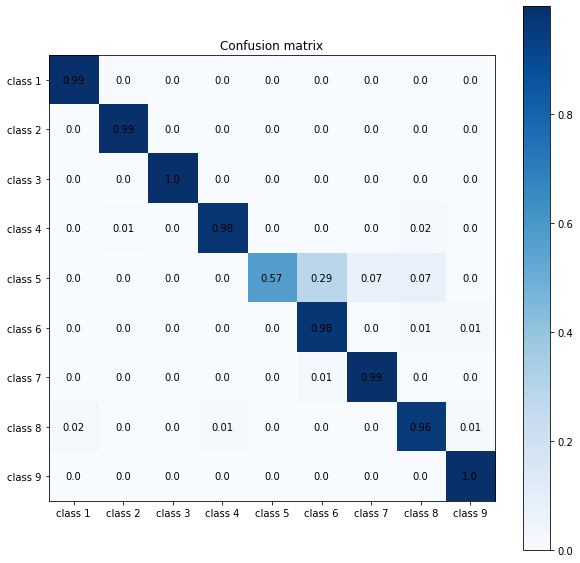

In [76]:
#ADASYN
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

### undersample

Logloss:0.0747708142571249
Accuracy:0.9812940815700705


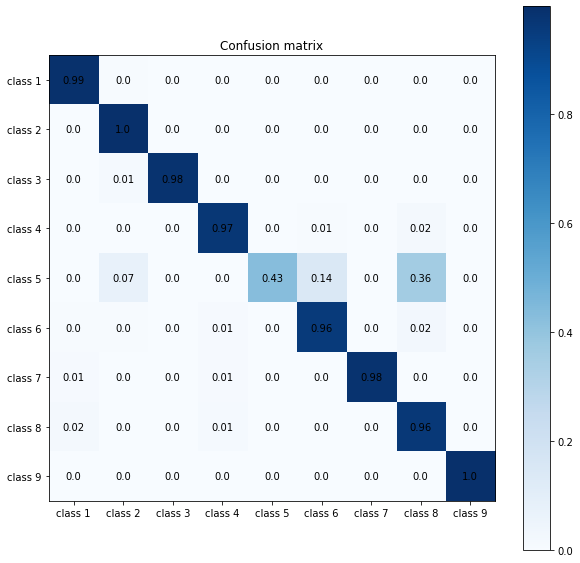

In [67]:
#RandomUnderSampler
X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

## bagging

Logloss:0.06151399825050501
Accuracy:0.9846672799754677


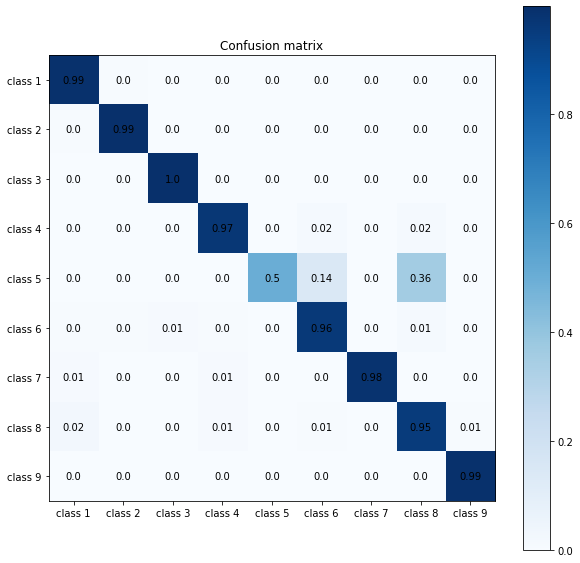

In [175]:

# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

#X=selected_features.iloc[:,1:110]
#y=features.iloc[:,1]

X=selected_features.iloc[:,1:110]
X_train, X_test, y_train, y_test = train_test_split( X, features['Class'], test_size=0.3, random_state=47)

param = {
    'booster' : 'gbtree',
    'eval_metric' : 'logloss',
    'scale_pos_weight' : 1.0,
    'nthread' : 8,
    'bst:colsample_bytree' : 0.5,
    #'seed' = seed,
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 9}  # the number of classes that exist in this datset
exgb_classifier = xgb.XGBClassifier()
exgb_classifier.set_params(**param)

y_train = [int(x-1) for x in y_train]
y_test = [int(x-1) for x in y_test]

# define the model
model = BaggingClassifier(base_estimator=exgb_classifier,n_estimators=5, random_state=0, n_jobs=-1).fit(X_train, y_train)
# evaluate the model
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
model.score(X_test, y_test)

pred=model.predict(X_test)
pred_prob=model.predict_proba(X_test)

score_log = log_loss(y_test,pred_prob,eps=1e-15)
score_acc = accuracy_score(y_test, pred)

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred)

### bagging impl

In [137]:
#kfold i bagging

#from sklearn.cross_validation import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import StratifiedKFold
import random

X=selected_features.iloc[:,1:110]
y=features.iloc[:,1]
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1000)

predicted = []
original = []
log_losses = []
accuracies = []
f1_scores = []
fold_counter = 0
misclassified_counter = 1
for train_index, test_index in kfold.split(X,y):
    fold_counter += 1
    train_X=X.iloc[train_index,:]
    train_y=y.iloc[train_index]
    test_X=X.iloc[test_index,:]
    test_y=y.iloc[test_index]
    
    bags = 10
    test_pred_prob = np.zeros((len(test_index),9))
    for bg in range(bags):
        seed = bg + 1
        new_train_index = random.sample(list(train_index), int(len(train_index) * 1.))

        for i in range(int(len(train_index) * 1.)):
            new_train_index.append(random.choice(train_index))

        train_X=X.iloc[new_train_index,:]
        train_y=y.iloc[new_train_index]

        pred = xgboost_basic(train_X, test_X, train_y)

        print("Bag " + str(bg+1))

        test_pred_prob += pred[1]

    pred_prob = test_pred_prob / bags

    best_preds = np.asarray([np.argmax(line) for line in pred_prob])

    #print (best_preds)
    
    #predicted.extend(pred_class)
    #original.extend(class_labels[test_index])

    #if pred_prob != None:
    test_y = [int(x-1) for x in test_y]
    score_log = log_loss(test_y,pred_prob,eps=1e-15)
    score_acc = accuracy_score(test_y, best_preds)

    log_losses.append(log_loss)
    #else:
    #    log_losses.append(np.inf)
    accuracies.append(accuracy_score)
    #f1_scores.append(f1_score(test_actual_labels, pred_class, average='weighted'))
    print('-----------------------------------')
    print('FOLD '+ str(fold_counter))
    print('Logloss:' + str(score_log))
    print('Accuracy:' + str(score_acc))

#    for i in range(len(pred_class)):
#        if pred_class[i] != test_y[i]:
#            print misclassified_counter,'==>', test_MD5[i], 'actual='+str(test_actual_labels[i]), \
#                   'predicted='+str(pred_class[i]), 'actual probability='+ str(pred_prob[i, test_id_num[i]]), \
#                    'predicted probability='+ str(pred_prob[i, name_dictionary[pred_class[i]]])
#            misclassified_counter += 1

#predicted = np.array(predicted)
#original = np.array(original)
print ('===========================================')
#print('In total {} misclassified samples'.format(misclassified_counter-1))
print('Accuracy mean : ' + str(np.mean(accuracies)))
#print('F1_score mean : ' + str(np.mean(f1_scores)))
print('log loss mean : ' + str(np.mean(log_losses)))


Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10
-----------------------------------
FOLD 0
Logloss:0.02698799734969553
Accuracy:0.9917203311867525
Bag 1
Bag 2
Bag 3
Bag 4
Bag 5
Bag 6
Bag 7
Bag 8
Bag 9
Bag 10
-----------------------------------
FOLD 0
Logloss:0.04916041673398885
Accuracy:0.984360625574977
Bag 1


KeyboardInterrupt: 

In [177]:
#nešto krivo

X=selected_features.iloc[:,1:110]
y=features.iloc[:,1]
# scikit-learn bootstrap
from sklearn.utils import resample
# data sample
data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# prepare bootstrap sample
y_train = resample(y, replace=True, n_samples=8000, random_state=1)
# out of bag observations
y_test = [x for x in y if x not in y_train]
X_train=X.iloc[y_train,:]
X_test=X.iloc[y_test,:]
print(X_train)
print(X_test)
print(y_train)
print(y_test)

pred = xgboost_basic(X_train, X_test, y_train)

y_test = [int(x-1) for x in y_test]
score_log = log_loss(y_test,pred[1],eps=1e-15)
score_acc = accuracy_score(y_test, pred[0])

print('Logloss:' + str(score_log))
print('Accuracy:' + str(score_acc))

make_and_plot_confusion_matrix(y_test,pred[0])

          PC1        PC2       PC3       PC4       PC5        PC6       PC7  \
1    6.134662  -0.169692 -3.905000  3.035733  0.640184   3.231605 -1.170238   
3   24.334193  24.624190 -2.402030 -2.457468 -7.806197 -11.639498 -1.542437   
1    6.134662  -0.169692 -3.905000  3.035733  0.640184   3.231605 -1.170238   
6    7.076132   1.068227 -2.068956 -1.743873 -3.593075   1.352266 -0.155878   
2    4.059810  -3.441866 -3.402326  1.966009 -0.498861   3.190550 -0.307942   
..        ...        ...       ...       ...       ...        ...       ...   
7    6.156747  -0.663735 -2.310588 -0.437389 -2.169731  -0.821575 -0.911456   
3   24.334193  24.624190 -2.402030 -2.457468 -7.806197 -11.639498 -1.542437   
6    7.076132   1.068227 -2.068956 -1.743873 -3.593075   1.352266 -0.155878   
3   24.334193  24.624190 -2.402030 -2.457468 -7.806197 -11.639498 -1.542437   
9   17.234887  15.693757 -0.765676  4.902730  5.990514 -11.284782  5.852182   

         PC8       PC9      PC10  ...     PC100    

ValueError: y_true and y_pred contain different number of classes 4, 9. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [3 4 5 6]